# Описание проекта

Требуется подготовить прототип модели машинного обучения, предсказывающей коэффициент восстановления золота из золотосодержащей руды. Даны данные с параметрами добычи и очистки. 

# План действий
1. **Подготовить данные**

    1.1. Открыть файлы и изучить их.
    
    1.2. Проверить, что эффективность обогащения рассчитана правильно. Вычислить её на обучающей выборке для признака rougher.output.recovery. Найте MAE между нашими расчётами и значением признака. Описать выводы.
    
    1.3. Проанализировать признаки, недоступные в тестовой выборке (что за параметры, к какому типу относятся).
    
    1.4. Провести предобработку данных.
    
    
2. **Проанализировать данные**

    2.1. Посмотреть, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Описать выводы.
    
    2.2. Сравнить распределения размеров гранул сырья на обучающей и тестовой выборках (если распределения сильно отличаются друг от друга, оценка модели будет неправильной).
    
    2.3. Исследовать суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 
    Есть ли аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Описать выводы и удалить аномалии.
    
    
3. **Построить модель**

    3.1. Написать функцию для вычисления итоговой sMAPE.
    
    3.2. Обучить разные модели и оценить их качество кросс-валидацией. Выбрать лучшую модель и проверить её на тестовой выборке. Описать выводы.

# Описание данных

#### Технологический процесс

*Rougher feed* — исходное сырье

*Rougher additions (reagent additions)* — флотационные реагенты: Xanthate, Sulphate, Depressant

   - *Xanthate* — ксантогенат (промотер, или активатор флотации);

   - *Sulphate* — сульфат (на данном производстве сульфид натрия);

   - *Depressant* — депрессант (силикат натрия).

*Rougher process* — флотация

*Rougher tails* — отвальные хвосты

*Float banks* — флотационная установка

*Cleaner process* — очистка

*Rougher Au* — черновой концентрат золота

*Final Au* — финальный концентрат золота

#### Параметры этапов

*air amount* — объём воздуха

*fluid levels* — уровень жидкости

*feed size* — размер гранул сырья

*feed rate* — скорость подачи

#### Наименование признаков

Наименование признаков должно быть такое:
`[этап].[тип_параметра].[название_параметра]`

Пример: `rougher.input.feed_ag`

Возможные значения для блока `[этап]`:

*rougher* — флотация

*primary_cleaner* — первичная очистка

*secondary_cleaner* — вторичная очистка

*final* — финальные характеристики

Возможные значения для блока `[тип_параметра]`:

*input* — параметры сырья

*output* — параметры продукта

*state* — параметры, характеризующие текущее состояние этапа

*calculation* — расчётные характеристики

---
---
# 1. Подготовка данных

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

---
## 1.1 Откроем файлы и изучим их

In [2]:
# Читаем датасеты

# Обучающая выборка
data_train = pd.read_csv("/datasets/gold_recovery_train.csv")
# Тестовая выборка
data_test = pd.read_csv("/datasets/gold_recovery_test.csv")
# Исходные данные
data_full = pd.read_csv("/datasets/gold_recovery_full.csv")

In [3]:
# Для вывода колонок
pd.set_option('display.max_columns', None)

# Для вывода строк
pd.set_option('display.max_rows', None)

In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

In [5]:
data_train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16788.000000,16788.000000,16490.000000,16789.000000,15339.000000,16794.000000,16677.000000,16715.000000,16794.000000,15553.000000,15598.000000,16860.000000,15875.000000,16778.000000,16502.000000,16224.000000,16778.000000,16777.000000,16761.000000,16579.000000,16777.000000,16820.000000,16827.000000,16820.000000,16833.000000,16822.000000,16833.000000,16821.000000,16833.000000,1.683300e+04,1.683300e+04,1.683300e+04,15618.000000,16778.000000,16632.000000,16347.000000,16443.000000,16568.000000,16777.000000,15816.000000,16514.000000,16237.000000,14956.000000,16778.000000,16778.000000,16698.000000,16778.000000,14287.000000,14610.000000,16778.000000,14611.000000,14611.000000,16807.000000,16807.000000,16807.000000,16807.000000,16807.000000,16814.000000,16802.000000,16809.000000,16257.000000,16809.000000,16802.000000,16802.000000,16776.000000,16764.000000,14874.000000,16778.000000,16497.000000,16751.000000,16705.000000,16748.000000,16763.000000,16747.000000,16752.000000,16750.000000,16731.000000,16747.000000,16768.000000,16767.000000,16775.000000,16775.000000,16775

In [6]:
data_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [7]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

In [8]:
data_test.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5554.000000,5572.000000,5856.000000,5690.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5816.000000,5834.000000,5789.000000,5840.000000,5599.000000,5733.000000,5801.000000,5503.000000,5839.000000,5840.000000,5839.000000,5840.000000,5839.000000,5840.000000,5839.000000,5840.000000,5839.000000,5840.000000,5839.000000,5840.000000,5836.000000,5840.000000,5833.000000,5840.000000,5822.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,170.515243,8.482873,7.264651,1.321420,1481.990241,-509.057796,1486.908670,-511.743956,1468.495216,-509.741212,1486.398557,-510.723606,8.736170,3.552722,458.485472,55.937535,35.105834,8.700930,13.439933,6.169553,13.056047,6.423566,1016.294703,-404.977728,1270.598553,-482.154567,1253.495045,-480.945868,1169.675564,-482.152253,1018.386311,-476.551547,962.005375,-477.795380,25.479808,-513.714941,21.083475,-512.325717,24.345831,-519.417733,20.068079,-515.028316,15.636031,-516.266074,13.145702,-476.338907,12.308967,-512.208126,9.470986,-505.017827,16.678722,-512.351694
std,49.608602,3.353105,0.611526,0.693246,310.453166,61.339256,313.224286,67.139074,309.980748,62.671873,313.725248,65.417633,2.985805,1.326113,155.958272,22.724254,10.793249,2.803046,3.997715,1.673606,4.533948,1.120371,226.494775,100.953782,285.247715,55.399631,290.703157,53.759053,285.407244,54.967985,231.675756,67.002595,220.862435,68.342305,5.450424,62.448366,5.940017,63.376776,7.950733,73.968109,7.644391,60.457838,4.660835,62.756748,4.304086,105.549424,3.762827,58.864651,3.312471,68.785898,5.404514,69.919839
min,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,0.000000,-799.838846,0.000000,0.000000,0.002986,0.046369,0.000000,0.000000,0.000154,0.000052,0.000014,0.000055,-0.123194,-657.949759,-0.821921,-650.349159,-0.282087,-650.000000,-1.047388,-648.390665,-2.076798,-650.152533,-2.593390,-650.034631,0.000000,-799.608557,0.000000,-798.467243,0.000000,-799.7

In [9]:
data_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

In [10]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

In [11]:
data_full.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,22627.000000,22629.000000,22331.000000,22630.000000,20753.000000,22633.000000,22516.000000,22445.000000,22635.000000,21107.000000,21170.000000,22716.000000,21565.000000,22618.000000,22268.000000,21918.000000,22618.000000,22614.000000,22594.000000,22365.000000,22617.000000,22660.000000,22667.000000,22660.000000,22673.000000,22662.000000,22673.000000,22661.000000,22673.000000,2.267200e+04,2.267200e+04,2.267200e+04,21089.000000,22618.000000,22472.000000,22163.000000,22277.000000,22357.000000,22617.000000,21415.000000,22247.000000,22038.000000,20459.000000,22618.000000,22618.000000,22526.000000,22618.000000,19597.000000,19979.000000,22618.000000,19980.000000,19980.000000,22646.000000,22647.000000,22646.000000,22647.000000,22646.000000,22654.000000,22641.000000,22649.000000,22096.000000,22649.000000,22641.000000,22642.000000,22616.000000,22600.000000,20501.000000,22618.000000,22333.000000,22591.000000,22538.000000,22588.000000,22585.000000,22587.000000,22592.000000,22590.000000,22571.000000,22587.000000,22608.000000,22607.000000,22615.000000,22615.000000,22615

In [12]:
data_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [13]:
# Посмотрим пропуски
data_train.isna().sum()

date                                                     0
final.output.concentrate_ag                             72
final.output.concentrate_pb                             72
final.output.concentrate_sol                           370
final.output.concentrate_au                             71
final.output.recovery                                 1521
final.output.tail_ag                                    66
final.output.tail_pb                                   183
final.output.tail_sol                                  145
final.output.tail_au                                    66
primary_cleaner.input.sulfate                         1307
primary_cleaner.input.depressant                      1262
primary_cleaner.input.feed_size                          0
primary_cleaner.input.xanthate                         985
primary_cleaner.output.concentrate_ag                   82
primary_cleaner.output.concentrate_pb                  358
primary_cleaner.output.concentrate_sol                 6

### Выводы по п.1.1
Открыли и изучили датасеты. Признаки именуются по шаблону `[этап].[тип_параметра].[название_параметра]` Часть данных с пропусками. В тестовом датасете отсутствуют признаки, которые есть в тренировочном датасете.

---
## 1.2 Проверим, что эффективность обогащения рассчитана правильно. 

In [14]:
#Нужно смоделировать процесс восстановления золота из золотосодержащей руды.
#Эффективность обогащения рассчитывается по формуле Recovery = (C*(F-T)/F*(C-T))*100%
#C — доля золота в концентрате после флотации/очистки; final.output.concentrate_au 
#F — доля золота в сырье/концентрате до флотации/очистки; rougher.input.feed_au  
#T — доля золота в отвальных хвостах после флотации/очистки.final.output.tail_au 

f_t = data_train['rougher.input.feed_au'] - data_train['final.output.tail_au']
c_t = data_train['final.output.concentrate_au'] - data_train['final.output.tail_au']
data_train['final.output.recovery_count'] = ((data_train['final.output.concentrate_au']*f_t)/(data_train['rougher.input.feed_au']*c_t))*100

#на случай -inf
data_train['final.output.recovery_count'].replace([np.inf, -np.inf], np.nan,inplace=True)

#на случай отрицательных значений
data_train[data_train['final.output.recovery_count'] < 0] = 0 

#на случай сильно положительных значений
data_train[data_train['final.output.recovery_count'] > 100] = 100 


In [15]:
data_train[['final.output.recovery','final.output.recovery_count']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 2 columns):
final.output.recovery          15504 non-null float64
final.output.recovery_count    15504 non-null float64
dtypes: float64(2)
memory usage: 263.6 KB


In [16]:
# Уберем пропуски в final.output.recovery в data_train чтобы MAE не ругалась
data_train_wo_nan = data_train.dropna(subset=['final.output.recovery'])
data_train_wo_nan.reset_index(drop=True,inplace=True)

In [17]:
#Считаем MAE
mae_recovery = mean_absolute_error(data_train_wo_nan['final.output.recovery'],data_train_wo_nan['final.output.recovery_count'])
print('MAE =',mae_recovery)

MAE = 8.071428444199153e-15


### Выводы по п.1.2
Проверили правильность расчета эффективности обогащения `final.output.recovery`. 
Вычислили её по формуле и сохранили в тренировочном датасете в столбце `rougher.output.recovery_count`. 
Нашли **MAE = 8.071428444199153e-15** между нашими расчётами и значением признака в датасете. 
MAE близка к 0, значит эффективность обогащения `final.output.recovery` указана правильно.

---
## 1.3 Проанализируем признаки, недоступные в тестовой выборке

In [18]:
#Проанализируем признаки, недоступные в тестовой выборке
data_train_cols = data_train.columns #признаки тренировочной выборки
data_test_cols = data_test.columns #признаки тестовой выборки

train_not_test = data_train_cols.difference(data_test_cols) #признаки, которых нет в тесте
print(data_train[train_not_test].dtypes)

final.output.concentrate_ag                           float64
final.output.concentrate_au                           float64
final.output.concentrate_pb                           float64
final.output.concentrate_sol                          float64
final.output.recovery                                 float64
final.output.recovery_count                           float64
final.output.tail_ag                                  float64
final.output.tail_au                                  float64
final.output.tail_pb                                  float64
final.output.tail_sol                                 float64
primary_cleaner.output.concentrate_ag                 float64
primary_cleaner.output.concentrate_au                 float64
primary_cleaner.output.concentrate_pb                 float64
primary_cleaner.output.concentrate_sol                float64
primary_cleaner.output.tail_ag                        float64
primary_cleaner.output.tail_au                        float64
primary_

### Выводы по п.1.3
Признаки, недоступные в тестовой выборке это параметры, получаемые путем расчетов либо по окончании какой-либо из стадий золотообработки. 

---
## 1.4 Проведем предобработку данных.

In [19]:
# рассчитаем rougher.output.recovery для тренировочной выборки
#Эффективность обогащения рассчитывается по формуле Recovery = (C*(F-T)/F*(C-T))*100%
#C — доля золота в концентрате после флотации/очистки; rougher.output.concentrate_au 
#F — доля золота в сырье/концентрате до флотации/очистки; rougher.input.feed_au  
#T — доля золота в отвальных хвостах после флотации/очистки.rougher.output.tail_au 
f_t = data_train['rougher.input.feed_au'] - data_train['rougher.output.tail_au']
c_t = data_train['rougher.output.concentrate_au'] - data_train['rougher.output.tail_au']
data_train['rougher.output.recovery_count'] = ((data_train['rougher.output.concentrate_au']*f_t)/(data_train['rougher.input.feed_au']*c_t))*100

#на случай -inf 
data_train['rougher.output.recovery_count'].replace([np.inf, -np.inf], np.nan,inplace=True)

#на случай отрицательных значений
data_train[data_train['rougher.output.recovery_count'] < 0] = 0 
#на случай сильно положительных значений
data_train[data_train['rougher.output.recovery_count'] > 100] = 100 

In [20]:
data_train[['rougher.output.recovery','rougher.output.recovery_count']].head()

,rougher.output.recovery,rougher.output.recovery_count
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794


In [21]:
data_train[['rougher.output.recovery','rougher.output.recovery_count']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 2 columns):
rougher.output.recovery          14587 non-null float64
rougher.output.recovery_count    14422 non-null float64
dtypes: float64(2)
memory usage: 263.6 KB


In [22]:
# Пропуски в final.output.recovery заменим рассчитанными final.output.recovery_count
data_train['final.output.recovery'] = data_train['final.output.recovery'].fillna(data_train['final.output.recovery_count'])

In [23]:
# Пропуски в rougher.output.recovery заменим рассчитанными rougher.output.recovery_count
data_train['rougher.output.recovery'] = data_train['rougher.output.recovery'].fillna(data_train['rougher.output.recovery_count'])

In [24]:
# Уберем оставшиеся пропуски в final.output.recovery и в rougher.output.recovery в data_train
data_train.dropna(subset=['final.output.recovery'],inplace=True)
data_train.dropna(subset=['rougher.output.recovery'],inplace=True)
data_train.reset_index(drop=True,inplace=True)

### Выводы по шагу 1.4
Выполнили предварительную обработку данных - пропуски в целевых признаках `final.output.recovery` и `rougher.output.recovery` заменили расчетными `final.output.recovery_count` и `rougher.output.recovery_count`, оставшиеся удалили. Последующая обработка будет сделана на шаге 3, поскольку часть данных нам еще нужна для шага 2.

---
---
# 2. Анализ данных

## 2.1 Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f810b206310>,
      dtype=object)

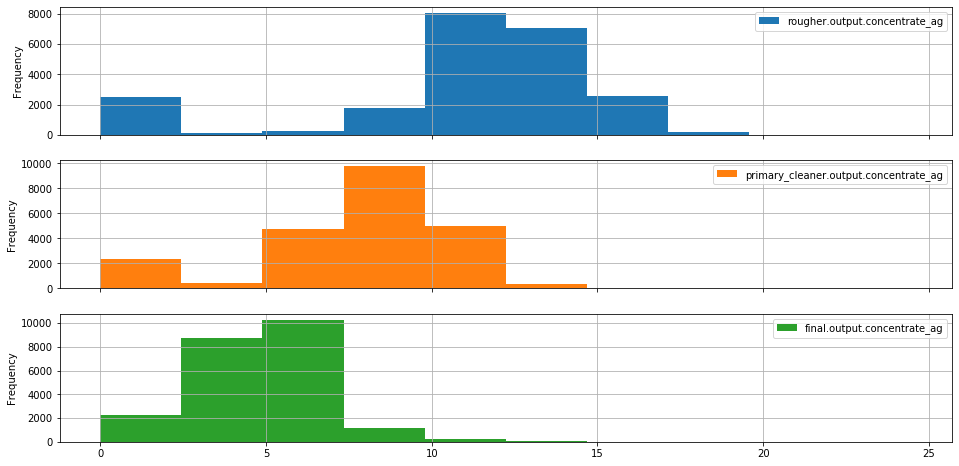

In [25]:
#Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.
#Ag - серебро
data_full_concentrate_ag = data_full[['rougher.output.concentrate_ag','primary_cleaner.output.concentrate_ag','final.output.concentrate_ag']]
data_full_concentrate_ag.plot(kind='hist', subplots=True, grid=True, legend=True,figsize=(16,8))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f810af92b50>,
      dtype=object)

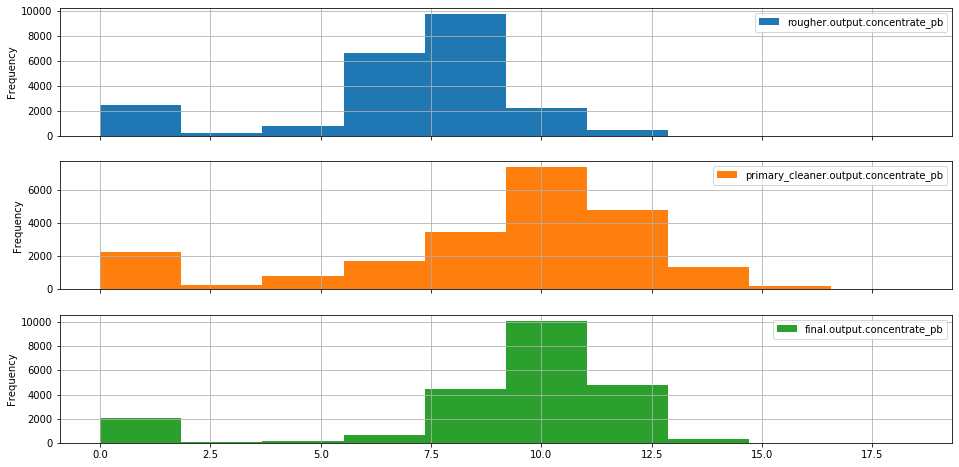

In [26]:
#Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.
#Pb - свинец
data_full_concentrate_pb = data_full[['rougher.output.concentrate_pb','primary_cleaner.output.concentrate_pb','final.output.concentrate_pb']]
data_full_concentrate_pb.plot(kind='hist', subplots=True, grid=True, legend=True,figsize=(16,8))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f810af17190>,
      dtype=object)

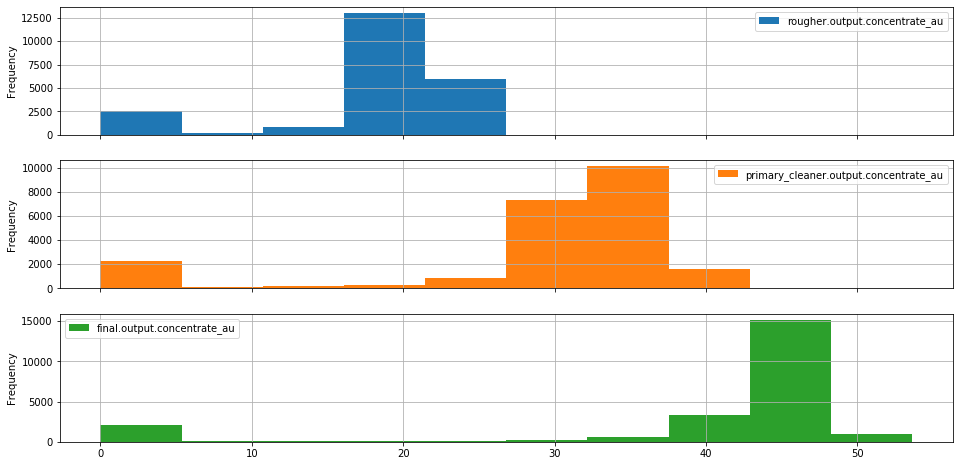

In [27]:
#Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.
#Au - золото
data_full_concentrate_au = data_full[['rougher.output.concentrate_au','primary_cleaner.output.concentrate_au','final.output.concentrate_au']]
data_full_concentrate_au.plot(kind='hist', subplots=True, grid=True, legend=True,figsize=(16,8))

### Выводы по п.2.1
Изменения в концентрации металлов при прохождении различных стадий золотообработки следующие:
- концентрация серебра (Ag) постепенно с каждой стадией становится все меньше и за полный процесс уменьшается в 2 раза.
- концентрация свинца (Pb) увеличивается на четверть лишь вначале - после процесса флотации, а после двух стадий очистки остается неизменной.
- концентрация золота (Au) после каждой стадии увеличивается и к окончанию процессу увеличивается более чем вдвое.

---
## 2.2 Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.

Гранулы сырья при подаче на флотацию


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8106ba7fd0>,
      dtype=object)

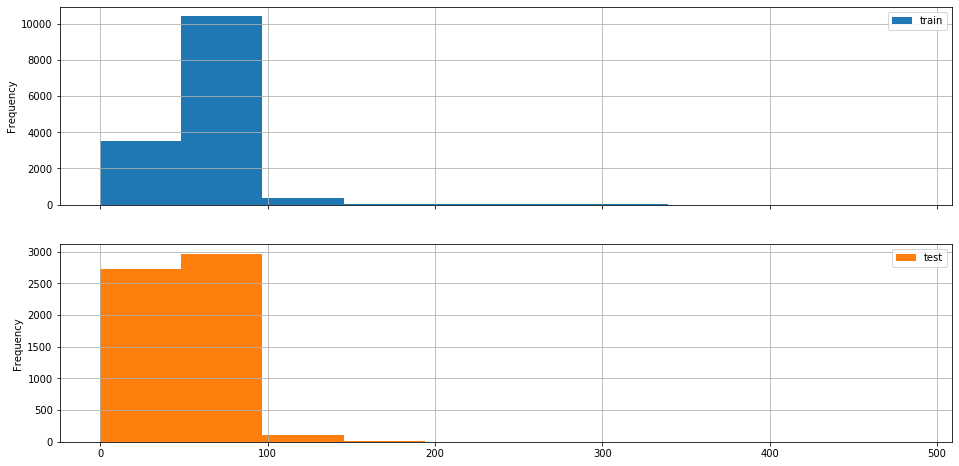

In [28]:
#Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. 
print("Гранулы сырья при подаче на флотацию")
data_rougher_input_feed_size = pd.DataFrame(data={'train': data_train['rougher.input.feed_size'], 'test': data_test['rougher.input.feed_size']})
data_rougher_input_feed_size.plot(kind='hist', subplots=True, grid=True, legend=True,figsize=(16,8))

Гранулы сырья при подаче на первичную очистку


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8106aa4490>,
      dtype=object)

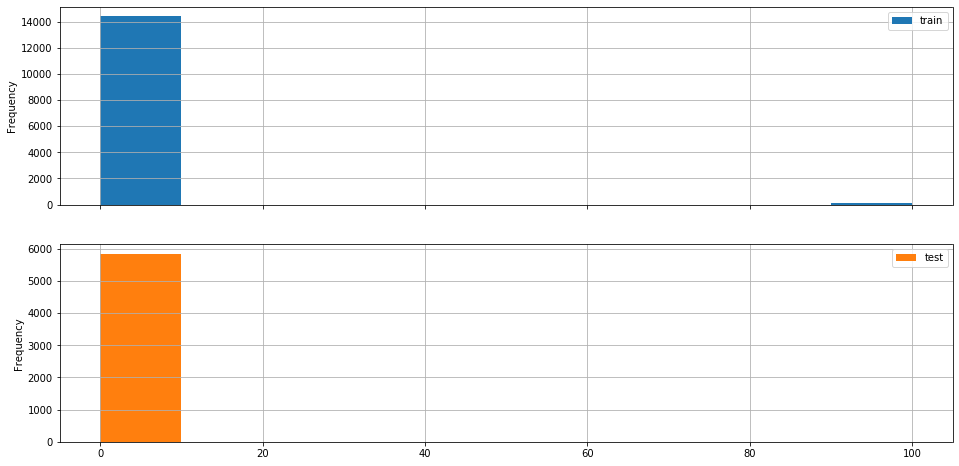

In [29]:
print("Гранулы сырья при подаче на первичную очистку")
data_primary_cleaner_input_feed_size = pd.DataFrame(data={'train': data_train['primary_cleaner.input.feed_size'], 'test': data_test['primary_cleaner.input.feed_size']})
data_primary_cleaner_input_feed_size.plot(kind='hist', subplots=True, grid=True, legend=True,figsize=(16,8))

### Выводы по п.2.2 
Сравнили распределения размеров гранул сырья на обучающей и тестовой выборках. Распределения не отличаются друг от друга, значит оценка модели будет правильной.

---
## 2.3 Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

Суммарная концентрация всех веществ в сырье (тренировочная выборка)


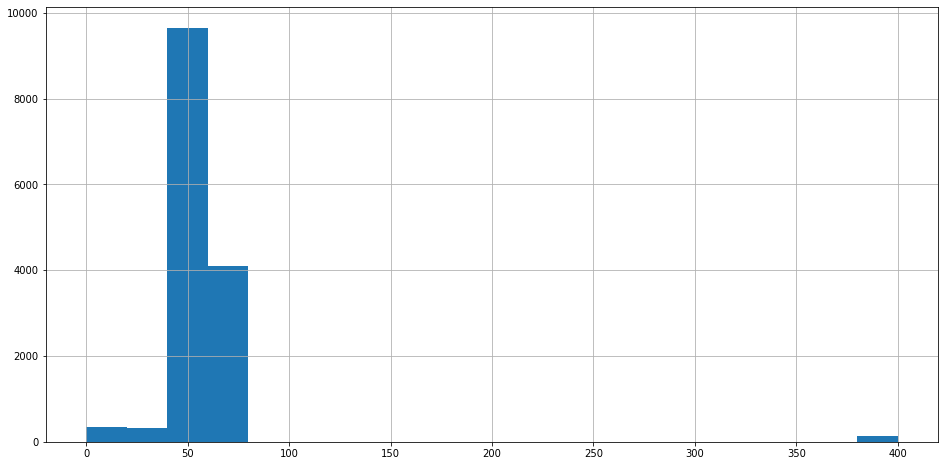

In [30]:
#Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.
# в сырье в обучающей выборке
print('Суммарная концентрация всех веществ в сырье (тренировочная выборка)')
rougher_input_sum_elements = ['rougher.input.feed_ag','rougher.input.feed_pb','rougher.input.feed_sol','rougher.input.feed_au']
data_train['rougher.input.sum_elements'] = data_train[rougher_input_sum_elements].sum(axis=1)
data_train['rougher.input.sum_elements'].hist(bins=20,figsize=(16,8)) 

Суммарная концентрация всех веществ в черновом концентрате (тренировочная выборка)


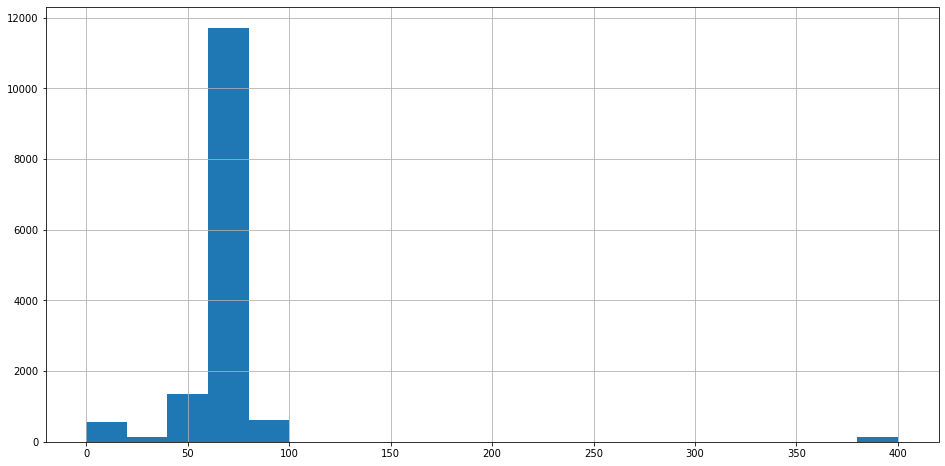

In [31]:
#Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.
# в черновом в обучающей выборке
print('Суммарная концентрация всех веществ в черновом концентрате (тренировочная выборка)')
rougher_output_sum_elements = ['rougher.output.concentrate_ag','rougher.output.concentrate_pb','rougher.output.concentrate_sol','rougher.output.concentrate_au']
data_train['rougher.output.sum_elements'] = data_train[rougher_output_sum_elements].sum(axis=1)
data_train['rougher.output.sum_elements'].hist(bins=20,figsize=(16,8)) 

Суммарная концентрация всех веществ в финальном концентрате (тренировочная выборка)


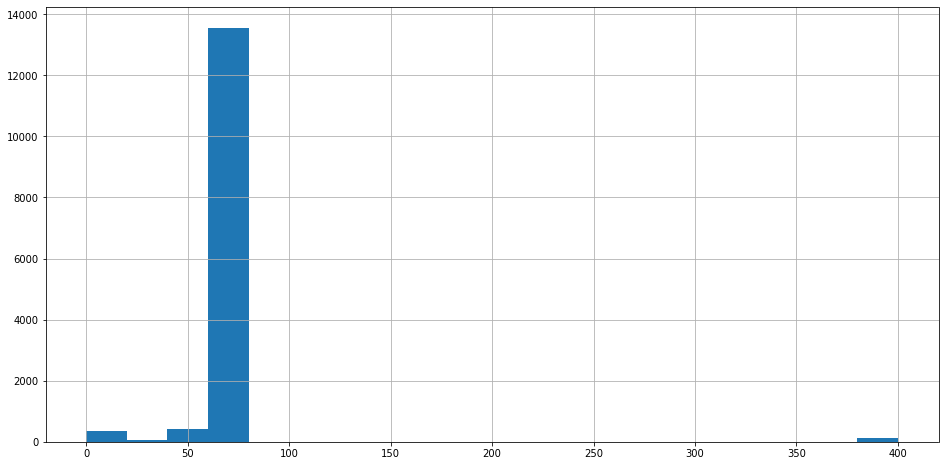

In [32]:
#Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.
# в финальном в обучающей выборке
print('Суммарная концентрация всех веществ в финальном концентрате (тренировочная выборка)')
final_output_sum_elements = ['final.output.concentrate_ag','final.output.concentrate_pb','final.output.concentrate_sol','final.output.concentrate_au']
data_train['final.output.sum_elements'] = data_train[final_output_sum_elements].sum(axis=1)
data_train['final.output.sum_elements'].hist(bins=20,figsize=(16,8)) 

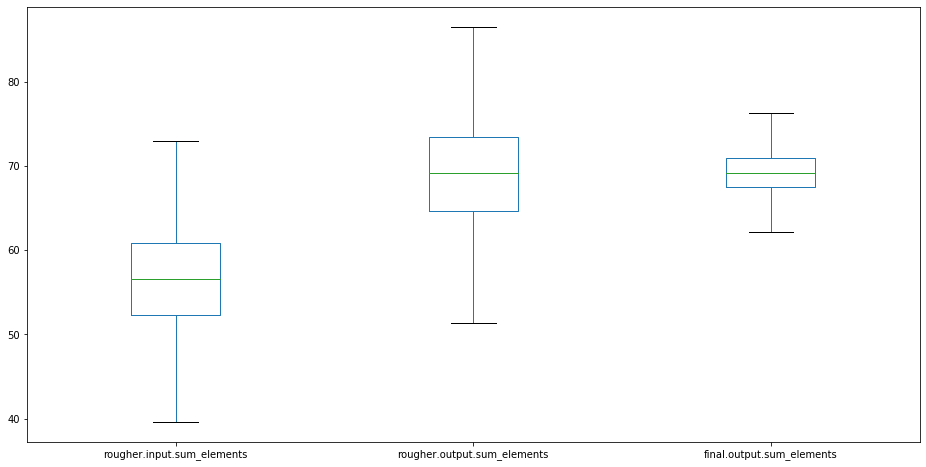

In [33]:
# Строим ящики с усами
sum_elements = ['rougher.input.sum_elements','rougher.output.sum_elements','final.output.sum_elements']
data_train[sum_elements].plot(kind='box',subplots=False,showfliers=False, figsize=(16,8))

In [34]:
# Функция удаления аномалий
def BordersCalc(param,feat):

    res_des = param.describe()
    iqr = res_des[6] - res_des[4]
    k_box = 3
    k_garbage = 1.5
    
    #Считаем границы отсечения
    garbage_bot = res_des[4]-k_garbage*iqr
    if garbage_bot < res_des[3]:
        garbage_bot = res_des[3]

    garbage_top = res_des[6]+k_garbage*iqr
    if garbage_top > res_des[7]:
        garbage_top = res_des[7]
    
    print('Отбрасываем значения',feat,'<',garbage_bot,'и >',garbage_top)
    garbage =[garbage_bot,garbage_top]
    return garbage

In [35]:
#Отбросим аномалии в обучающем датасете только в тех признаках, которые есть в тестовом датасете
# 'rougher.input.feed_ag','rougher.input.feed_pb','rougher.input.feed_sol','rougher.input.feed_au'
garbage = BordersCalc(data_train['rougher.input.feed_ag'],'rougher.input.feed_ag')
data_train_wo_anomaly = data_train[(data_train['rougher.input.feed_ag'] >= garbage[0]) & (data_train['rougher.input.feed_ag'] <= garbage[1])]

garbage = BordersCalc(data_train['rougher.input.feed_pb'],'rougher.input.feed_pb')
data_train_wo_anomaly = data_train_wo_anomaly[(data_train_wo_anomaly['rougher.input.feed_pb'] >= garbage[0]) & (data_train_wo_anomaly['rougher.input.feed_pb'] <= garbage[1])]

garbage = BordersCalc(data_train['rougher.input.feed_sol'],'rougher.input.feed_sol')
data_train_wo_anomaly = data_train_wo_anomaly[(data_train_wo_anomaly['rougher.input.feed_sol'] >= garbage[0]) & (data_train_wo_anomaly['rougher.input.feed_sol'] <= garbage[1])]

garbage = BordersCalc(data_train['rougher.input.feed_au'],'rougher.input.feed_au')
data_train_wo_anomaly = data_train_wo_anomaly[(data_train_wo_anomaly['rougher.input.feed_au'] >= garbage[0]) & (data_train_wo_anomaly['rougher.input.feed_au'] <= garbage[1])]

data_train_wo_anomaly.reset_index(drop=True,inplace=True)

Отбрасываем значения rougher.input.feed_ag < 2.8377053635555933 и > 14.196056619017302
Отбрасываем значения rougher.input.feed_pb < 0.5218688057838317 и > 6.467436743658157
Отбрасываем значения rougher.input.feed_sol < 25.686130311091738 и > 47.71129341801008
Отбрасываем значения rougher.input.feed_au < 2.729092689399776 и > 12.909330341726614


Суммарная концентрация всех веществ в сырье (тестовая выборка)


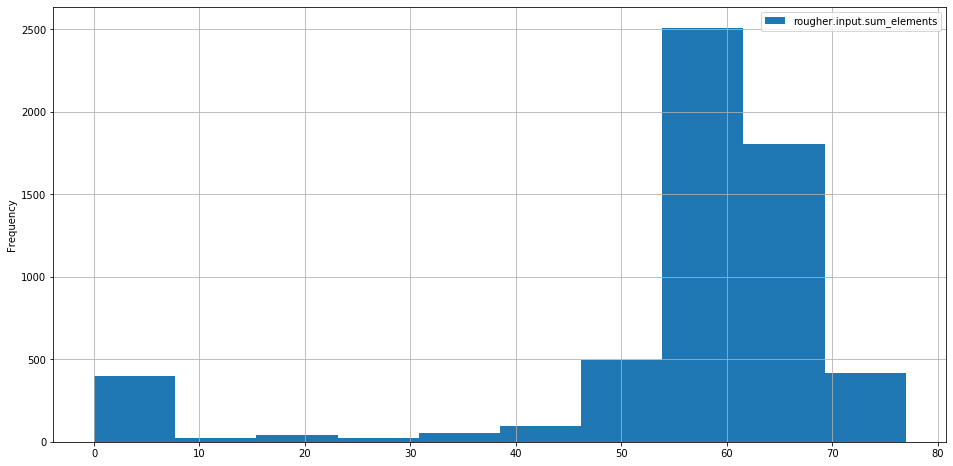

In [36]:
#Исследуем суммарную концентрацию всех веществ в сырье в тестовой выборке
print('Суммарная концентрация всех веществ в сырье (тестовая выборка)')
rougher_input_sum_elements = ['rougher.input.feed_ag','rougher.input.feed_pb','rougher.input.feed_sol','rougher.input.feed_au']
data_test['rougher.input.sum_elements'] = data_test[rougher_input_sum_elements].sum(axis=1)
data_test['rougher.input.sum_elements'].plot(kind='hist', grid=True, legend=True,figsize=(16,8))

### Выводы по шагу 2.3
Исследовали суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили большие аномальные значения и удалили их в обучающей выборке (только для тех признаков, которые есть в тестовой выборке, поскольку остальные мы все равно удалим на следующем шаге). Тестовую выборку трогать не стали.

---
---
# 3. Построим модель

## 3.0 Дообработка данных

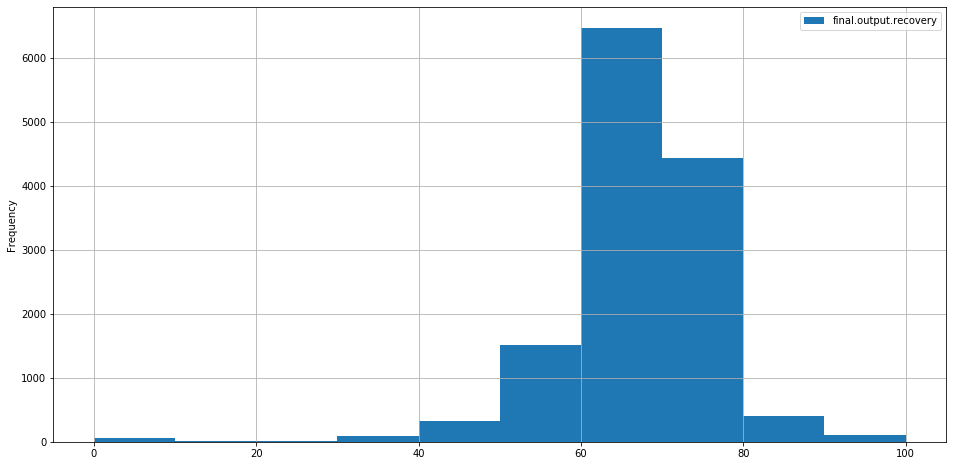

In [38]:
data_train_wo_anomaly['final.output.recovery'].plot(kind='hist', grid=True, legend=True,figsize=(16,8))

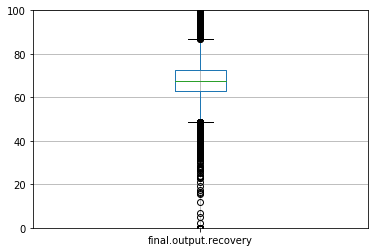

In [39]:
plt.ylim(0, 100)
data_train_wo_anomaly.boxplot('final.output.recovery')

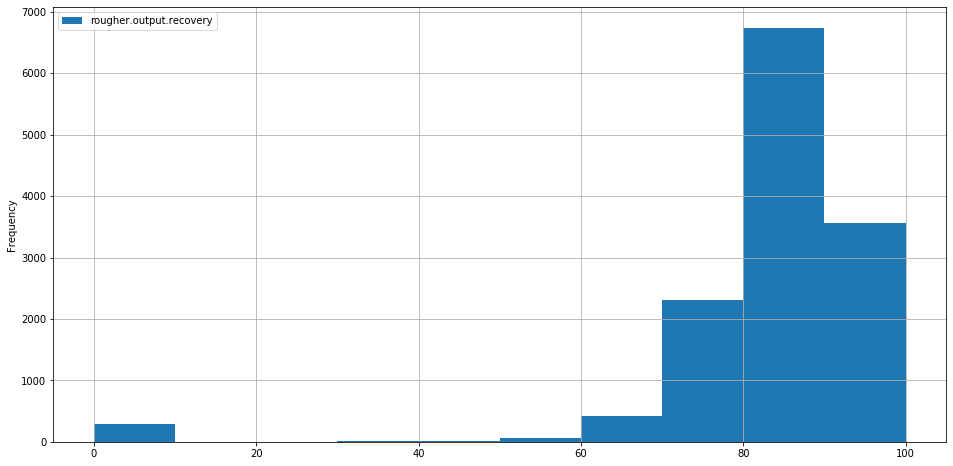

In [40]:
data_train_wo_anomaly['rougher.output.recovery'].plot(kind='hist', grid=True, legend=True,figsize=(16,8))

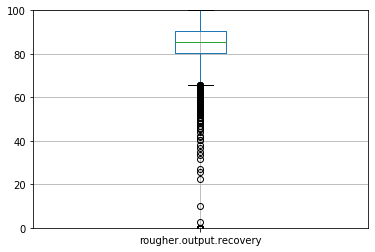

In [41]:
plt.ylim(0, 100)
data_train_wo_anomaly.boxplot('rougher.output.recovery')

In [42]:
# Убираем выбросы из целевых признаков
garbage = BordersCalc(data_train_wo_anomaly['rougher.output.recovery'],'rougher.output.recovery')
data_train_wo_anomaly = data_train_wo_anomaly[(data_train_wo_anomaly['rougher.output.recovery'] >= garbage[0]) & (data_train_wo_anomaly['rougher.output.recovery'] <= garbage[1])]

garbage = BordersCalc(data_train_wo_anomaly['final.output.recovery'],'final.output.recovery')
data_train_wo_anomaly = data_train_wo_anomaly[(data_train_wo_anomaly['final.output.recovery'] >= garbage[0]) & (data_train_wo_anomaly['final.output.recovery'] <= garbage[1])]


Отбрасываем значения rougher.output.recovery < 65.59252157335331 и > 99.97904061775264
Отбрасываем значения final.output.recovery < 49.53979020728009 и > 86.40518315448942


In [43]:
# удалим из списка отсутствующих в тестовом датасете признаков final.output.recovery и rougher.output.recovery 
train_not_test = train_not_test.drop(['final.output.recovery','rougher.output.recovery'])

# удалим из тренировочного датасета признаки, отсутствующие в тестовом датасете
data_train_wo_anomaly.drop(train_not_test,axis=1,inplace = True)

In [44]:
# удалим признаки, полученные в результате наших расчетов и пр 
train_calc = ['date','rougher.output.recovery_count','rougher.input.sum_elements','rougher.output.sum_elements','final.output.sum_elements']
data_train_wo_anomaly.drop(train_calc,axis=1,inplace = True)

In [45]:
data_train_wo_anomaly.reset_index(drop=True,inplace=True)

In [46]:
#список признаков трейна
data_train_columns = data_train_wo_anomaly.columns.tolist()

#список целевых признаков
data_train_columns_drop = ['final.output.recovery','rougher.output.recovery']

#список признаков трейна без целевых
data_train_columns_real = list(set(data_train_columns) - set(data_train_columns_drop))

In [47]:
#заполняем пропуски в признаках трейна по ffill
for i in range(0,len(data_train_columns_real),1):
    data_train_wo_anomaly[data_train_columns_real[i]] = data_train_wo_anomaly[data_train_columns_real[i]].fillna(method='ffill') 

In [48]:
# Делим обучающий датасет на признаки и целевые признаки
target_rougher = data_train_wo_anomaly['rougher.output.recovery']
target_final = data_train_wo_anomaly['final.output.recovery']
features_final = data_train_wo_anomaly.drop(['rougher.output.recovery','final.output.recovery'],axis=1)
features_rougher = features_final

In [49]:
# Из data_train процесс обогащения выделим в отдельный датасет 
columns_rougher_sel = ['rougher.input.feed_ag','rougher.input.feed_pb','rougher.input.feed_rate','rougher.input.feed_size','rougher.input.feed_sol','rougher.input.feed_au','rougher.input.floatbank10_sulfate','rougher.input.floatbank10_xanthate','rougher.input.floatbank11_sulfate','rougher.input.floatbank11_xanthate','rougher.output.recovery','rougher.state.floatbank10_a_air','rougher.state.floatbank10_a_level','rougher.state.floatbank10_b_air','rougher.state.floatbank10_b_level','rougher.state.floatbank10_c_air','rougher.state.floatbank10_c_level','rougher.state.floatbank10_d_air','rougher.state.floatbank10_d_level','rougher.state.floatbank10_e_air','rougher.state.floatbank10_e_level','rougher.state.floatbank10_f_air','rougher.state.floatbank10_f_level']  
data_train_rougher_sel = data_train_wo_anomaly[columns_rougher_sel]

columns_drop_sel = ['rougher.output.recovery']
columns_real_sel = list(set(columns_rougher_sel) - set(columns_drop_sel))

features_rougher_sel = data_train_rougher_sel.drop(['rougher.output.recovery'],axis=1)

In [50]:
# Разделим обучающий датасет на обучающую и проверочную выборки
features_final_train, features_final_valid, target_final_train, target_final_valid = train_test_split(features_final, target_final, test_size=0.25, random_state=12345)
features_rougher_train, features_rougher_valid, target_rougher_train, target_rougher_valid = train_test_split(features_rougher, target_rougher, test_size=0.25, random_state=12345)

### Выводы по п.3.0
Что сделано с тренировочным датасетом:
- удалили выбросы в целевых признаках.
- удалили признаки, отсутствующие в тестовом датасете.
- удалили признаки, которые мы получили в предыдущих расчетах.
- заполнили пропуски в признаках по ffill.
- разделили тренировочный датасет на признаки и целевые признаки.
- из тренировочного датасета признаки, имеющие отношение к стадии обогащения, выделили в отдельный датасет (во избежание утечки целевого признака).

---
## 3.1 Напишем функцию для вычисления итоговой sMAPE

In [51]:
# функция для вычисления sMAPE
# y - Значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество.
# predictions - Значение предсказания для объекта с порядковым номером i, например, в тестовой выборке.

def SmapeCalc(y,predictions):
    N = len(y) 
    result = 0
    result = np.sum(2 * np.abs(y - predictions)/(np.abs(y) + np.abs(predictions)))
    smape = (1/N) * result * 1
    return smape

In [52]:
# функция для вычисления итоговой sMAPE

def ProfitSmapeCalc(target_final,pred_final,target_rougher,pred_rougher):
    smape_final = SmapeCalc(target_final,pred_final)
    smape_rougher = SmapeCalc(target_rougher,pred_rougher)
    profit_smape = 0.25*smape_rougher + 0.75*smape_final
        
    return profit_smape

### Выводы по п.3.1
Функция для вычисления итогового sMAPE написана.

---
## 3.2 Обучим разные модели и оценим их качество кросс-валидацией. Выберем лучшую модель и проверим её на тестовой выборке.

In [53]:
#Обучите разные модели и оцените их качество кросс-валидацией

In [54]:
# Масштабируем признаки 
scaler = StandardScaler()
scaler.fit(features_final_train)

features_final_train = scaler.transform(features_final_train)
features_final_valid = scaler.transform(features_final_valid)

features_rougher_train = scaler.transform(features_rougher_train)
features_rougher_valid = scaler.transform(features_rougher_valid)

In [55]:
# Линейная регрессия с масштабированием 
model_line_final = LinearRegression()
model_line_final.fit(features_final_train, target_final_train)
print('Линейная регрессия',model_line_final.score(features_final_valid, target_final_valid))


Линейная регрессия 0.3772303100686707


In [56]:
# Дерево решений - подбор гиперпараметров (после подбора код закомментирован, поскольку долго выполняется)
#best_depth_tree = 0
#best_score = 0
#for depth in range(1, 20, 1):
#    model_tree_final = DecisionTreeRegressor(random_state=12345, max_depth=depth)
#    model_tree_final.fit(features_final_train,target_final_train)
#    model_tree_final_score = model_tree_final.score(features_final_valid, target_final_valid)
#    if model_tree_final_score > best_score:
#        best_depth_tree = depth
#        best_score = model_tree_final_score
#        best_model_tree_final = model_tree_final 
#print('В дереве решений максимальный результат',best_score,'при количестве веток',best_depth_tree)
best_depth_tree = 8

In [57]:
# Случайный лес - подбор гиперпараметров веток (после подбора код закомментирован, поскольку долго выполняется)
#best_depth = 0
#best_score = 0
#for depth in range(1, 61, 2):
#    model_forest_final = RandomForestRegressor(n_estimators=20, max_depth=depth, random_state=12345)
#    model_forest_final.fit(features_final_train, target_final_train)
#    model_forest_final_score = model_forest_final.score(features_final_valid, target_final_valid)
#    if model_forest_final_score > best_score:
#        best_depth = depth
#        best_score = model_forest_final_score
#print('В случайном лесе при 20 деревьях максимальный результат',best_score,'при количестве веток',best_depth)
best_depth = 29 #количество веток

In [58]:
# Случайный лес - подбор гиперпараметров деревьев (после подбора код закомментирован, поскольку долго выполняется)
#best_estim = 0
#best_score = 0
#for estim in range(1, 133, 2):
#    model_forest_final = RandomForestRegressor(n_estimators=estim, max_depth=29, random_state=12345)
#    model_forest_final.fit(features_final_train, target_final_train)
#    model_forest_final_score = model_forest_final.score(features_final_valid, target_final_valid)
#    if model_forest_final_score > best_score:
#        best_estim = estim
#        best_score = model_forest_final_score
#        best_model_forest_final = model_forest_final 
#print('В случайном лесе максимальный результат',best_score,'при количестве деревьев',best_estim,'и количестве веток',best_depth)
best_estim = 107 #количество деревьев

In [59]:
# Готовим тестовую выборку data_test_with_recovery 

# удалим признаки, полученные в результате наших расчетов
test_calc = ['rougher.input.sum_elements']
data_test.drop(test_calc,axis=1,inplace = True)


# добавим из полного датасета в тестовый датасет признаки final.output.recovery и rougher.output.recovery
data_test_with_recovery = data_test.merge(data_full[['date','rougher.output.recovery','final.output.recovery']], on='date', how='left')

#удалим оставшиеся пропуски в final.output.recovery и rougher.output.recovery
data_test_with_recovery.dropna(subset=['final.output.recovery'], inplace = True)
data_test_with_recovery.dropna(subset=['rougher.output.recovery'], inplace = True)
data_test_with_recovery.reset_index(drop=True,inplace=True)

#оставшиеся пропуски заполним по ffill
for i in range(0,len(data_train_columns_real),1):
    data_test_with_recovery[data_train_columns_real[i]] = data_test_with_recovery[data_train_columns_real[i]].fillna(method='ffill') 

#разделим на features и target
target_rougher_test = data_test_with_recovery['rougher.output.recovery']
target_final_test = data_test_with_recovery['final.output.recovery']
features_final_test = data_test_with_recovery.drop(['date','rougher.output.recovery','final.output.recovery'],axis=1) #'rougher.output.recovery',
features_rougher_test = features_final_test

columns_rougher_sel = ['rougher.input.feed_ag','rougher.input.feed_pb','rougher.input.feed_rate','rougher.input.feed_size','rougher.input.feed_sol','rougher.input.feed_au','rougher.input.floatbank10_sulfate','rougher.input.floatbank10_xanthate','rougher.input.floatbank11_sulfate','rougher.input.floatbank11_xanthate','rougher.state.floatbank10_a_air','rougher.state.floatbank10_a_level','rougher.state.floatbank10_b_air','rougher.state.floatbank10_b_level','rougher.state.floatbank10_c_air','rougher.state.floatbank10_c_level','rougher.state.floatbank10_d_air','rougher.state.floatbank10_d_level','rougher.state.floatbank10_e_air','rougher.state.floatbank10_e_level','rougher.state.floatbank10_f_air','rougher.state.floatbank10_f_level']  
features_rougher_test_sel = features_rougher_test[columns_rougher_sel]



In [60]:
# Масштабируем признаки
scaler = StandardScaler()
scaler.fit(features_final)

features_final = scaler.transform(features_final)
features_rougher = scaler.transform(features_rougher)
features_final_test = scaler.transform(features_final_test)

scaler.fit(features_rougher_sel)
features_rougher_sel = scaler.transform(features_rougher_sel)
features_rougher_test_sel = scaler.transform(features_rougher_test_sel)

In [61]:
#делаем скор из функции по расчету sMAPE 
smape_loss  = make_scorer(SmapeCalc, greater_is_better=False)
smape_score = make_scorer(SmapeCalc, greater_is_better=True) # для кросс-валидации

In [62]:
# оценим качество моделей кросс-валидацией, выберем лучшую
blocks_number = 5 #количество блоков

model_line_final = LinearRegression()
final_score = cross_val_score(model_line_final, features_final, target_final, scoring=smape_score,cv=blocks_number).mean()
print('Среднее sMAPE модели линейной регрессии:', final_score)

model_tree_final = DecisionTreeRegressor(random_state=12345, max_depth=best_depth_tree)
final_score = cross_val_score(model_tree_final, features_final, target_final, scoring=smape_score, cv=blocks_number).mean()
print('Среднее sMAPE модели решающего дерева:', final_score)

model_forest_final = RandomForestRegressor(n_estimators=best_estim, max_depth=best_depth, random_state=12345)
final_score = cross_val_score(model_forest_final, features_final, target_final, scoring=smape_score, cv=blocks_number).mean()
print('Среднее sMAPE модели случайного леса:', final_score)

Среднее sMAPE модели линейной регрессии: 0.0783572003134932
Среднее sMAPE модели решающего дерева: 0.08436313725165764
Среднее sMAPE модели случайного леса: 0.07033189454517359


In [63]:
# Лучшая модель - случайный лес
#model_forest_final = RandomForestRegressor(n_estimators=best_estim, max_depth=best_depth, random_state=12345)
best_model = model_forest_final 

In [64]:
# Проверим качество модели на тестовой выборке

# Обучаем модель на final  
best_model.fit(features_final, target_final)
pred_final_test = best_model.predict(features_final_test)

# Обучаем модель на rougher
best_model.fit(features_rougher_sel, target_rougher)
pred_rougher_test_sel = best_model.predict(features_rougher_test_sel)

#pred_rougher_test_sel = pd.Series(pred_rougher_test_sel)

#Считаем итоговый sMAPE для тестовой выборки
profit_smape = ProfitSmapeCalc(target_final_test,pred_final_test,target_rougher_test,pred_rougher_test_sel)
print('Итоговый sMAPE',profit_smape)

Итоговый sMAPE 0.08885714430980537


In [65]:
# проверим модель на адекватность
# среднее сделаем предсказанием
# посчитаем итоговое sMAPE для константной модели
pred_final_const = pd.Series(target_final.mean(), index=target_final_test.index)
pred_rougher_const = pd.Series(target_rougher.mean(), index=target_rougher_test.index)
#print(pred_rougher_const)
profit_smape_const = ProfitSmapeCalc(target_final_test,pred_final_const,target_rougher_test,pred_rougher_const)
print('Итоговый sMAPE для константной модели',profit_smape_const)

Итоговый sMAPE для константной модели 0.09294419858344896


In [66]:
if profit_smape < profit_smape_const:
    print('Ура, наша модель вполне адекватна!')
else:
    print('Увы, наша модель не в адеквате...')

Ура, наша модель вполне адекватна!


### Выводы по п. 3.2
Обучили разные модели и оцените их качество кросс-валидацией. Выбрали лучшую модель (случайный лес) и проверили её на тестовой выборке. Проверили нашу модель на адекватность - сравнили ее с константной моделью, где все предсказания равны среднему целевому признаку. Модель оказалась вполне адекватна.